# Chapter 9 - Exercise 2
### Author: *John Benedick Estrada*
---
**Exercise:** In the first version of Sugarscape, we never add agents, so once the population falls, it never recovers.  In the second version, we only replace agents when they die, so the population is constant.  Now let's see what happens if we add some "population pressure".

Write a version of Sugarscape that adds a new agent at the end of every step.  Add code to compute the average vision and the average metabolism of the agents at the end of each step.  Run the model for a few hundred steps and plot the population over time, as well as the average vision and average metabolism.

You should be able to implement this model by inheriting from
`Sugarscape` and overriding `__init__` and `step`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from Cell2D import Cell2D, draw_array
from utils import decorate
from matplotlib.colors import LinearSegmentedColormap

##### Implementation of Sugarscape in Think Complexity 2nd Edition: Chapter 9
Source: https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/chap09.ipynb

In [2]:
class Agent:
    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

In [3]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)


def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)


def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)


class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        
        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

Demonstrations of the original Sugarscape

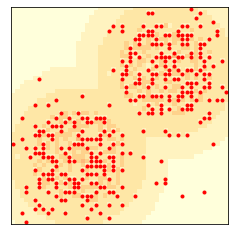

In [4]:
demo1 = Sugarscape(50, num_agents=400)
demo1.animate(10)

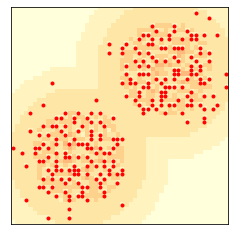

In [5]:
demo2 = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

demo2.animate(frames=30)

### My implementation of the new `Sugarscape` variant.

In [6]:
class NewSugarscape(Sugarscape):
    def __init__(self, n, **params):
        super().__init__(n, **params)
        
        # Add new quantities to track.
        self.ave_vision_list = []
        self.ave_metabolism_list = []

    def step(self):
        """Executes one time step."""
        # Step the simulation as usual.
        super().step()

        # Calculate average vision and metabolism of the current time
        # step and store them.
        self.ave_vision_list.append(self.ave_agent_attr("vision"))
        self.ave_metabolism_list.append(self.ave_agent_attr("metabolism"))
        
        # Add a new agent.
        self.add_agent()

        return len(self.agents)

    def ave_agent_attr(self, attr):
        return np.mean([getattr(agent, attr) for agent in self.agents])

In [7]:
max_time_step = 1000
new_env = NewSugarscape(n=50, num_agents=400)

We can see from the animation below that agents congregate in patches with rich resources. We have already seen this in the original Sugarscape. 

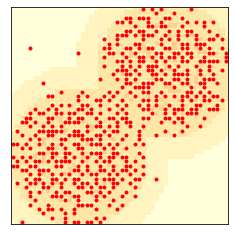

In [8]:
new_env.animate(max_time_step)

We see from the graph below (Number of Agents vs Time step), major culling occured in the first few time step (before, say, $t=100$) before the population count increases in a seemingly linear fashion.

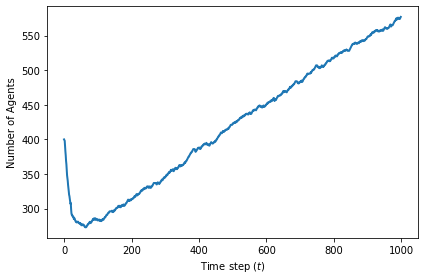

In [9]:
plt.plot(new_env.agent_count_seq)
decorate(xlabel="Time step ($t$)", ylabel="Number of Agents")

Interestingly, we see sudden improvement of vision in the population when the culling before $t=100$ was happening.

A way to interpret this is that agents with poor vision died quickly because, in general, they could not find a reliable source of sugar to feed themselves, while those with farther visions live on.

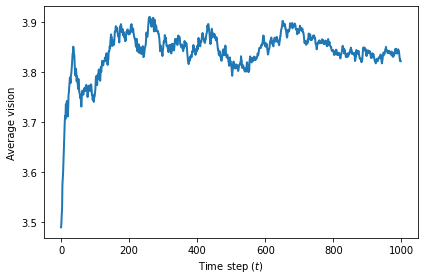

In [10]:
plt.plot(new_env.ave_vision_list)
decorate(xlabel="Time step ($t$)", ylabel="Average vision")

We also see the drop of metabolism indicating that agents left in later time steps on average consume sugar less than agents in earlier time steps.

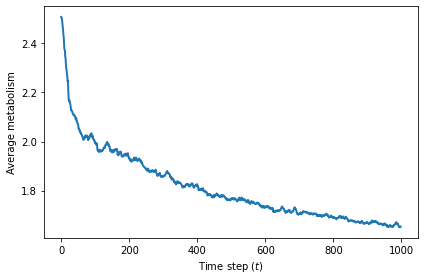

In [11]:
plt.plot(new_env.ave_metabolism_list)
decorate(xlabel="Time step ($t$)", ylabel="Average metabolism")

We can see this as a model for competition between individuals in a population. Generally, agents that could not find and secure reliable resources die off. And agents that are able to find and secure resource locations are those with better innate attributes (better vision which helps in finding resources and better metabolism to limit the use of resources). As such, more "superior" agents are those that have superior vision, and/or those that do need to transfer much due to their small metabolism (so they are entrenched in rich resource spots).

Furthermore, since rich resource patches are more likely to be occupied by the older "superior" agents in later time steps, newer agents would have a hard time to secure a spot with reliable sugar income. This forces agents to compete for the less rich resource patches. Eventually those with even lower metabolism will occupy those patches. We can see this in the animation above where the blob of agents slowly expanding from the center of the sugar patches and eventually filling those patches up. Another evidence of this is average metabolism still somewhat decreasing in mid and later time steps.

As with the original Sugarscape, we see agents flocking into patches with rich resources in the animation above. However, since those patches are not infinite, if we extend the simulation, we can expect that the population will reach a steady state where the population count fluctuating about some value.